# Cross sections following a cold pool

We define a cold pool location given by the strongest near-surface gradient of density potential temperature.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta

# trick to read function in a separate file
import sys
sys.path.append('/glade/u/home/rberrios/python/PRECIP/')
from defineColormaps import *

%matplotlib inline

Define functions that calculate thetaRho and that extract a cross section from point A to point B.

In [2]:
from scipy.interpolate import RegularGridInterpolator

def calculate_max_horizontal_gradient(thetaRho):
    """
    Calculates the horizontal gradient of an xarray DataArray with
    'latitude' and 'longitude' coordinates and finds the location
    of the maximum gradient magnitude.

    Args:
        thetaRho (xr.DataArray): An xarray DataArray with 'latitude' and
                                  'longitude' as coordinates.

    Returns:
        tuple: A tuple containing:
            - gradient_magnitude (xr.DataArray): The magnitude of the
              horizontal gradient.
            - lon_max (float): The longitude of the maximum gradient magnitude.
            - lat_max (float): The latitude of the maximum gradient magnitude.
    """

    # Calculate the gradient along the longitude dimension
    dthetaRho_dlon = thetaRho.differentiate('longitude')

    # Calculate the gradient along the latitude dimension
    dthetaRho_dlat = thetaRho.differentiate('latitude')

    # Calculate the magnitude of the horizontal gradient
    gradient_magnitude = np.sqrt(dthetaRho_dlon**2 + dthetaRho_dlat**2)

    # # Find the index of the maximum gradient magnitude
    # max_index = gradient_magnitude.argmax()
    # print(max_index)

    # # Get the longitude and latitude of the maximum gradient
    # lon_max = gradient_magnitude['longitude'].isel(longitude=max_index).item()
    # lat_max = gradient_magnitude['latitude'].isel(latitude=max_index).item()

    # Find the index of the maximum gradient magnitude using argmax on the flattened array
    max_index_flat = gradient_magnitude.argmax().item()

    # Get the multi-dimensional index from the flattened index
    multi_index = np.unravel_index(max_index_flat, gradient_magnitude.shape)
    print(multi_index)

    # Get the longitude and latitude of the maximum gradient using isel
    lon_max = gradient_magnitude['longitude'].isel(longitude=multi_index[1]).item()
    lat_max = gradient_magnitude['latitude'].isel(latitude=multi_index[0]).item()


    return gradient_magnitude, lon_max, lat_max
    
def vertical_cross_section_linear(ds, cLat, iLon, fLon, varName):
    """
    Extracts a vertical cross-section of wind data along a straight line, returning an array.

    Args:
        ds (xarray.Dataset): The xarray dataset containing wind data.
        cLat (float): Latitude of the cross section.
        iLon (float): Longitude of the starting point.
        fLon (float): Longitude of the ending point.

    Returns:
        numpy.ndarray: An array of shape (nLon, nz) containing the parallel wind.
    """

    cross_section = ds.sel(latitude=slice(cLat-0.5,cLat+0.5),longitude=slice(iLon,fLon))

    # read variable of interest
    if (varName == 'thetaRho') | (varName == 'buoyancy'):
        # density potential temperature to identify cold pools
        theta = cross_section['theta']
        qv = cross_section['qv']
        qc = cross_section['qc']
        qr = cross_section['qr']
        var = theta*(1.0 + (0.608*qv) - qc - qr)
        if (varName == 'buoyancy'):
            # get base state theta_rho: averaged over this domain
            thRhoBase = var.mean(dim=('longitude'))
            b = 9.81*(var-thRhoBase)/thRhoBase
            del(var)
            var = b
    # elif (varName == 'uzonal_isobaric'):
    #     print('warning: subtracting a fixed zonal speed')
    #     var = cross_section[varName]
    #     var = var-(-27.0)
    elif (varName == 'condensate'):
        var = cross_section['qc']+cross_section['qg']+cross_section['qs']+cross_section['qi']
    else:
        var = cross_section[varName]

    return var.mean('latitude').squeeze()

def vertical_cross_section_angled(ds, iLat, iLon, fLat, fLon, varName, 
                                  uzonal_var='uzonal_isobaric', umeridional_var='umeridional_isobaric', ndist=100,
                                 uMotion=0.0, vMotion=0.0):
    """
    Extracts a vertical cross-section of wind data along a straight line, returning an array.

    Args:
        ds (xarray.Dataset): The xarray dataset containing wind data.
        iLat (float): Latitude of the starting point.
        iLon (float): Longitude of the starting point.
        fLat (float): Latitude of the ending point.
        fLon (float): Longitude of the ending point.
        uzonal_var (str): Name of the zonal wind variable.
        umeridional_var (str): Name of the meridional wind variable.
        ndist (int): Number of grid points along the cross-section line.

    Returns:
        numpy.ndarray: An array of shape (ndist, nz) containing the parallel wind.
    """
    dist = np.sqrt((fLat - iLat)**2 + (fLon - iLon)**2)
    lat_points = np.linspace(iLat, fLat, ndist)
    lon_points = np.linspace(iLon, fLon, ndist)

    cross_section = ds.sel(latitude=slice(min(iLat, fLat), max(iLat, fLat)),
                           longitude=slice(min(iLon, fLon), max(iLon, fLon)))

    dlat = fLat - iLat
    dlon = fLon - iLon

    # read variable of interest
    if (varName == 'parallel_wind'):
        angle = np.arctan2(dlat, dlon)
    
        uzonal = cross_section[uzonal_var]
        umeridional = cross_section[umeridional_var]

        #subtract motion if given
        uzonal = uzonal - uMotion
        umeridional = umeridional - vMotion
    
        var = uzonal * np.cos(angle) + umeridional * np.sin(angle)
    elif (varName == 'thetaRho'):
        # density potential temperature to identify cold pools
        theta = cross_section['theta']
        qv = cross_section['qv']
        qc = cross_section['qc']
        qr = cross_section['qr']
        var = theta*(1.0 + (0.608*qv) - qc - qr)
    elif (varName == 'condensate'):
        var = cross_section['qc']+cross_section['qg']+cross_section['qs']+cross_section['qi']
    else:
        var = cross_section[varName]

    # define interpolation variable
    var_interp = np.zeros((var.shape[0],ndist))

    for z_index in range(var.shape[0]):
        # Interpolate using RegularGridInterpolator
        interp_func = RegularGridInterpolator((cross_section['longitude'].values, cross_section['latitude'].values),
                                             var[z_index,:].values.T,
                                             bounds_error=False, fill_value=None)

        # Create the interpolation points
        interp_points = np.array([lon_points, lat_points]).T

        var_interp[z_index, :] = interp_func(interp_points)

    da = xr.DataArray(var_interp, dims=[var.dims[0],'longitude'], coords=[var[var.dims[0]], lon_points])

    return da
    
def read_plot_cross_section_along_latitude(TODAY,HH,fhr,varName,minLat,maxLat,minLon,maxLon):
    validTime = initTime+timedelta(hours=(fhr))
    print(validTime)
    validTimeFormatted = datetime.strftime(initTime+timedelta(hours=(fhr)), '%Y-%m-%d_%H')
    
    # read file name as a dataset
    validTimeFormatted=datetime.strftime(datetime.strptime(TODAY+HH, '%Y%m%d%H')+timedelta(hours=(fhr)), '%Y-%m-%d_%H:%M')
    fname='%smpas_init_%s%s_valid_%s_latlon_%s.nc'%(outputDir,TODAY,HH,validTimeFormatted,domain)
    print(fname)
    ds = xr.open_dataset(fname).squeeze()

    # calculate density potential temperature to identify cold pools
    theta = ds['theta'].isel(nVertLevels=0).sel(latitude=slice(minLat,maxLat),longitude=slice(minLon,maxLon))
    qv = ds['qv'].isel(nVertLevels=0).sel(latitude=slice(minLat,maxLat),longitude=slice(minLon,maxLon))
    qc = ds['qc'].isel(nVertLevels=0).sel(latitude=slice(minLat,maxLat),longitude=slice(minLon,maxLon))
    qr = ds['qr'].isel(nVertLevels=0).sel(latitude=slice(minLat,maxLat),longitude=slice(minLon,maxLon))
    thetaRhoSurf = theta*(1.0 + (0.608*qv) - qc - qr)

    # now obtain the location of the max gradient
    # Calculate the horizontal gradient and find the maximum
    gradient_magnitude, max_lon, max_lat = calculate_max_horizontal_gradient(thetaRhoSurf)

    print("\nLongitude of Maximum Gradient:", max_lon)
    print("Latitude of Maximum Gradient:", max_lat)

    iLon = max_lon-2.0
    fLon = max_lon+2.0

    # # Extract the cross-section
    parallel_wind = vertical_cross_section_linear(ds, max_lat, iLon, fLon, 'uzonal_isobaric')
    print(parallel_wind.min().values,parallel_wind.max().values)
    w_wind = vertical_cross_section_linear(ds, max_lat, iLon, fLon, 'w_isobaric')
    z_iso = vertical_cross_section_linear(ds, max_lat, iLon, fLon, 'z_isobaric')*1.0e-3
    # field = vertical_cross_section_linear(ds, cLat, iLon, fLon, 'refl10cm')
    field = vertical_cross_section_linear(ds, max_lat, iLon, fLon, varName)
    del(ds)

    # now read vertical grid
    fname='/glade/work/rberrios/MPAS/cpex-cv/%s%s/latlon.nc'%(TODAY,HH)
    ds = xr.open_dataset(fname).squeeze()
    z_stag = vertical_cross_section_linear(ds, max_lat, iLon, fLon, 'zgrid')
    del(ds)
    # unstagger
    z_unstag = 0.5*(z_stag[1:,:]+z_stag[:-1,:])*0.001 # in km
       
    # Plotting the cross section:
    fig = plt.figure()
    [X, dummy] = np.meshgrid(field.longitude, np.arange(0,len(field[:,0])))
    plt.contourf(X, z_unstag, field,cmap='Spectral_r',levels=np.linspace(290,315,101))
                # levels=np.linspace(-10,65,31))
    plt.colorbar()

    # add wind vectors
    [X, Y] = np.meshgrid(field.longitude, w_wind.u_iso_levels)

    #Transpose wind components.
    plt.quiver(X[::,::5], z_iso[::,::5], parallel_wind[::,::5], 10.0*w_wind[::,::5],color='k')#, scale = 50, headwidth = 3) #Use transpose, and adjust scale.

    plt.ylim(0,4)
    plt.title(validTimeFormatted)
    display(fig)
    plt.close()

    # # check wind profile
    # fig=plt.figure()
    # uwind = parallel_wind.sel(longitude=max_lon-1.0,method='nearest')
    # z = z_iso.sel(longitude=max_lon-1.0,method='nearest')
    # plt.plot(uwind,uwind.u_iso_levels*0.01)
    # plt.title(validTimeFormatted)
    # plt.ylim(1000.0,600.0)
    # display(fig)
    # plt.close()

    # check line-perpendicular shear
    ushear = parallel_wind.sel(longitude=max_lon-1.0,u_iso_levels=650.0e2,method='nearest')-\
             parallel_wind.sel(longitude=max_lon-1.0,u_iso_levels=925.0e2,method='nearest')
    print('shear magnitude: %f'%(ushear.values))

    # check buoyancy
    refProf = field.sel(longitude=max_lon-1.0, method='nearest')
    buoyancy = 9.81*((field-refProf)/refProf)
    # i don't think we should only consider negative buoyancy, or yes... yes
    buoyancy = buoyancy.where(buoyancy<0.0,other=0.0)
    c = np.sqrt(-2.*np.trapz(buoyancy[0:24,:],z_unstag[0:24,:]*1.0e3,axis=0))
    print('cold pool strength: %f'%c.max())
    print('c/du: %f'%(c.max()/np.fabs(ushear.values)))

    return ushear.values, c.max()

Define basic parameters 

In [28]:
mainDir= '/glade/scratch/rberrios/2022-real-time-forecasts/'
mpasDir= '/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/'
TODAY='20220912'
HH='12'
initTime = datetime.strptime(TODAY+HH, '%Y%m%d%H')

outputDir = '%s%s%s_noomld/intrp_output/'%(mpasDir,TODAY,HH)

mpasStr='atl' 
domain = 'westAfrica'
varName = 'thetaRho'

minLat = 9.0-2.0
maxLat = 9.0+2.0
minLon = -17.0
maxLon = -10.0

This main function calls the cross section calculation and plotting.

### Publication quality plots

Define coordinates manually based on the other notebook that tracks the cold pool.

In [9]:
coordinates = {
    'northernSquall': {
        'land': {'lat':14.692, 'lon': -16.055, 'time': '2022-09-14 08:00:00'},
        'coast': {'lat':14.908,'lon':-17.35,'time':'2022-09-14 10:00:00'},
        'water': {'lat':15.222,'lon':-19.028,'time':'2022-09-14 13:00:00'}
    },
    'southernSquall': {
        'land': {'lat':9.361,'lon':-12.084, 'time':'2022-09-13 18:00:00'},
        'coast': {'lat':9.035,'lon':-13.536,'time':'2022-09-13 21:00:00'},
        'water': {'lat':9.226,'lon':-15.545,'time':'2022-09-14 03:00:00'}
    },
    'southernSquallNoon': {
        'land': {'lat':9.772,'lon':-10.383, 'time':'2022-09-13 12:00:00'},
        'coast': {'lat':8.839,'lon':-13.627,'time':'2022-09-13 18:00:00'},
        'water': {'lat':8.692,'lon':-15.746,'time':'2022-09-14 00:00:00'}
    },
}

### Cross sections perpendicular to the lines

2022-09-13 18:00:00 9.361 -12.084
7.361000000000001 11.361 -14.584 -9.584
2022-09-13 18:00:00
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld_perpnoon/intrp_output/mpas_init_2022091212_valid_2022-09-13_18:00_latlon_westAfrica.nc
291.1885070800781 307.89678955078125
<xarray.DataArray ()> Size: 8B
array(-12.96147287) <xarray.DataArray ()> Size: 8B
array(21.24058627)
<xarray.DataArray ()> Size: 8B
array(-1.25535033e-06) <xarray.DataArray ()> Size: 8B
array(0.00429198)


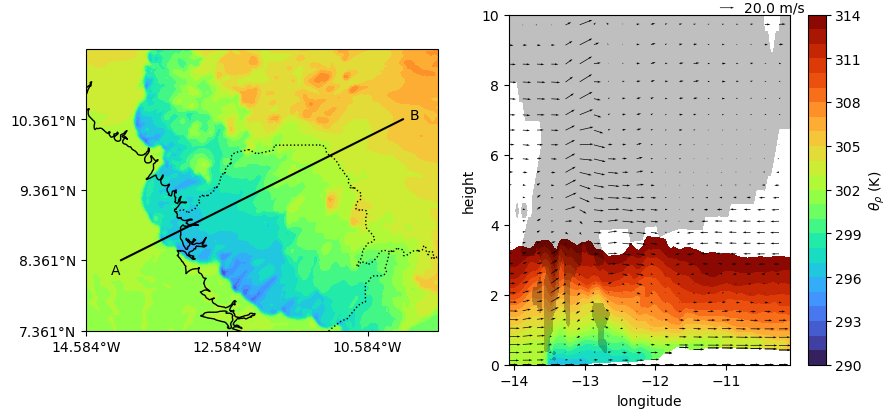

In [25]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

option = 'southernSquall'
location = 'land'

# read in info
centLat = coordinates[option][location]['lat']
centLon = coordinates[option][location]['lon']
time = coordinates[option][location]['time']
# time='2022-09-13 19:00:00'

validTime = datetime.strptime(time,'%Y-%m-%d %H:%M:%S')
print(validTime, centLat, centLon)

minLat = centLat-2.0
maxLat = centLat+2.0
minLon = centLon-2.5
maxLon = centLon+2.5
print(minLat,maxLat,minLon,maxLon)
lat_interval = 1.0
lon_interval = 2.0
num_rows = 2
num_cols = 2

fig = plt.figure(figsize=(10, 5 * num_rows))  # Adjust figure size as needed
gs = fig.add_gridspec(num_rows, num_cols) # Create grid specification

# Add the map panel to the first column
ax_map = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax_map.set_extent([minLon, maxLon, minLat, maxLat], crs=ccrs.PlateCarree()) # Set zoomed-in extent
ax_map.add_feature(cfeature.COASTLINE)
ax_map.add_feature(cfeature.BORDERS, linestyle=':')
# Add Latitudes
ax_map.set_yticks(np.arange(minLat, maxLat, lat_interval), crs=ccrs.PlateCarree())
lat_formatter = LatitudeFormatter()
ax_map.yaxis.set_major_formatter(lat_formatter)
# Add Longitudes
ax_map.set_xticks(np.arange(minLon, maxLon, lon_interval), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
ax_map.xaxis.set_major_formatter(lon_formatter)

# fhr = 49

# validTime = initTime+timedelta(hours=(fhr))
# read file name as a dataset
print(validTime)
validTimeFormatted = datetime.strftime(validTime, '%Y-%m-%d_%H:%M')
fname='%smpas_init_%s%s_valid_%s_latlon_%s.nc'%(outputDir,TODAY,HH,validTimeFormatted,domain)
print(fname)
ds = xr.open_dataset(fname).squeeze()

# calculate density potential temperature to identify cold pools
theta = ds['theta'].isel(nVertLevels=0).sel(latitude=slice(minLat,maxLat),longitude=slice(minLon,maxLon))
qv = ds['qv'].isel(nVertLevels=0).sel(latitude=slice(minLat,maxLat),longitude=slice(minLon,maxLon))
qc = ds['qc'].isel(nVertLevels=0).sel(latitude=slice(minLat,maxLat),longitude=slice(minLon,maxLon))
qr = ds['qr'].isel(nVertLevels=0).sel(latitude=slice(minLat,maxLat),longitude=slice(minLon,maxLon))
thetaRhoSurf = theta*(1.0 + (0.608*qv) - qc - qr)

print(thetaRhoSurf.min().values,thetaRhoSurf.max().values)

# redefine minLat, maxLat, etc for the cross section
minLon = centLon-2.0
maxLon = centLon+2.0
if (option == 'northernSquall'):
    minLat = centLat+0.5
    maxLat = centLat-0.5
    uMotion = -17.7
    vMotion = 6.6
else:
    minLat = centLat-1
    maxLat = centLat+1
    uMotion = -15.2
    vMotion = 2.2
# plot
[X, Y] = np.meshgrid(thetaRhoSurf.longitude, thetaRhoSurf.latitude)
ax_map.contourf(X,Y,thetaRhoSurf, cmap='turbo', levels = np.arange(290, 315, 1))
ax_map.plot([minLon, maxLon], [minLat, maxLat], color='k', transform=ccrs.PlateCarree())

# add A and B to cross section start and end
ax_map.text(minLon-0.15, minLat-0.2, 'A')
ax_map.text(maxLon+0.1, maxLat, 'B')
    
# # # Extract the cross-section
parallel_wind = vertical_cross_section_angled(ds, minLat, minLon, maxLat, maxLon, 'parallel_wind', uMotion=uMotion, vMotion=vMotion)
print(parallel_wind.min(),parallel_wind.max())
w_wind = vertical_cross_section_angled(ds, minLat, minLon, maxLat, maxLon, 'w_isobaric')
z_iso  = vertical_cross_section_angled(ds, minLat, minLon, maxLat, maxLon, 'z_isobaric')*1.0e-3
field1 = vertical_cross_section_angled(ds, minLat, minLon, maxLat, maxLon, varName)
field2 = vertical_cross_section_angled(ds, minLat, minLon, maxLat, maxLon, 'condensate')
print(field2.min(),field2.max())
del(ds)

# now read vertical grid
fname='/glade/work/rberrios/MPAS/cpex-cv/%s%s/latlon.nc'%(TODAY,HH)
ds = xr.open_dataset(fname).squeeze()
z_stag = vertical_cross_section_angled(ds, minLat, minLon, maxLat, maxLon, 'zgrid')
del(ds)
# unstagger
z_unstag = 0.5*(z_stag[1:,:].values+z_stag[:-1,:].values)*0.001 # in km

# Plotting the cross section:
# Get the SubplotSpec for the current Skew-T panel
subplot_spec = gs[0, 1]  # Skew-Ts are in the second and third columns

ax = fig.add_subplot(subplot_spec)

[X, dummy] = np.meshgrid(field1.longitude, np.arange(0,len(field1[:,0])))
im=ax.contourf(X, z_unstag, field1,cmap='turbo',levels=np.arange(290, 315, 1))
# plot the 1e-5 g/kg condensate isosurface
mask = field2 >= 1e-5
ax.contourf(X, z_unstag, mask,colors='k',alpha=0.25,levels=[0.5,1],extend='max')
ax.set(ylim=(0,10),ylabel='height',xlabel='longitude')

# add wind vectors
[X, Y] = np.meshgrid(field1.longitude, w_wind.u_iso_levels)
reference_magnitude_ms = 20.0  # Reference wind speed
desired_length_meters = 2000  # Desired arrow length on the plot in the units of X and z_iso

scale_factor = desired_length_meters / reference_magnitude_ms

Q = ax.quiver(X[::, ::5], z_iso[::, ::5], parallel_wind[::, ::5], 10.0 * w_wind[::, ::5],
              color='k', units='xy', scale_units='xy', scale=scale_factor)

# You can add a reference arrow and label for clarity
qk = ax.quiverkey(Q, 0.8, 1.02, reference_magnitude_ms, f'{reference_magnitude_ms} m/s',
                   labelpos='E', coordinates='axes')

# Q=ax.quiver(X[::,::5], z_iso[::,::5], parallel_wind[::,::5], 10.0*w_wind[::,::5],color='k') 
# # Add the reference vector using quiverkey
# qk = plt.quiverkey(Q, X=0.8, Y=1.02, U=30, label='25 m/s', labelpos='E')

cb=plt.colorbar(im)
cb.set_label(r'$\theta_{\rho}$ (K)')
# plt.savefig('./Figures/%s_%s.jpeg'%(option,location),bbox_inches='tight',dpi=150)

### Paneling the cross sections

2022-09-13 18:00:00 9.361 -12.084
7.361000000000001 11.361 -14.584 -9.584
2022-09-13 18:00:00
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld/intrp_output/mpas_init_2022091212_valid_2022-09-13_18:00_latlon_westAfrica.nc
288.66265869140625 310.1673889160156
<xarray.DataArray ()> Size: 8B
array(-19.16352803) <xarray.DataArray ()> Size: 8B
array(23.6927519)
<xarray.DataArray ()> Size: 8B
array(-8.49790764e-13) <xarray.DataArray ()> Size: 8B
array(0.0055409)
2022-09-13 21:00:00 9.035 -13.536
7.035 11.035 -16.036 -11.036
2022-09-13 21:00:00
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld/intrp_output/mpas_init_2022091212_valid_2022-09-13_21:00_latlon_westAfrica.nc
291.3716125488281 306.327880859375
<xarray.DataArray ()> Size: 8B
array(-14.60007082) <xarray.DataArray ()> Size: 8B
array(26.53284048)
<xarray.DataArray ()> Size: 8B
array(-8.08441069e-10) <xarray.DataArray ()> Size: 8B
array(0.0043289)
2022-09-14 03:00:00 9.226 -15.545
7.2260

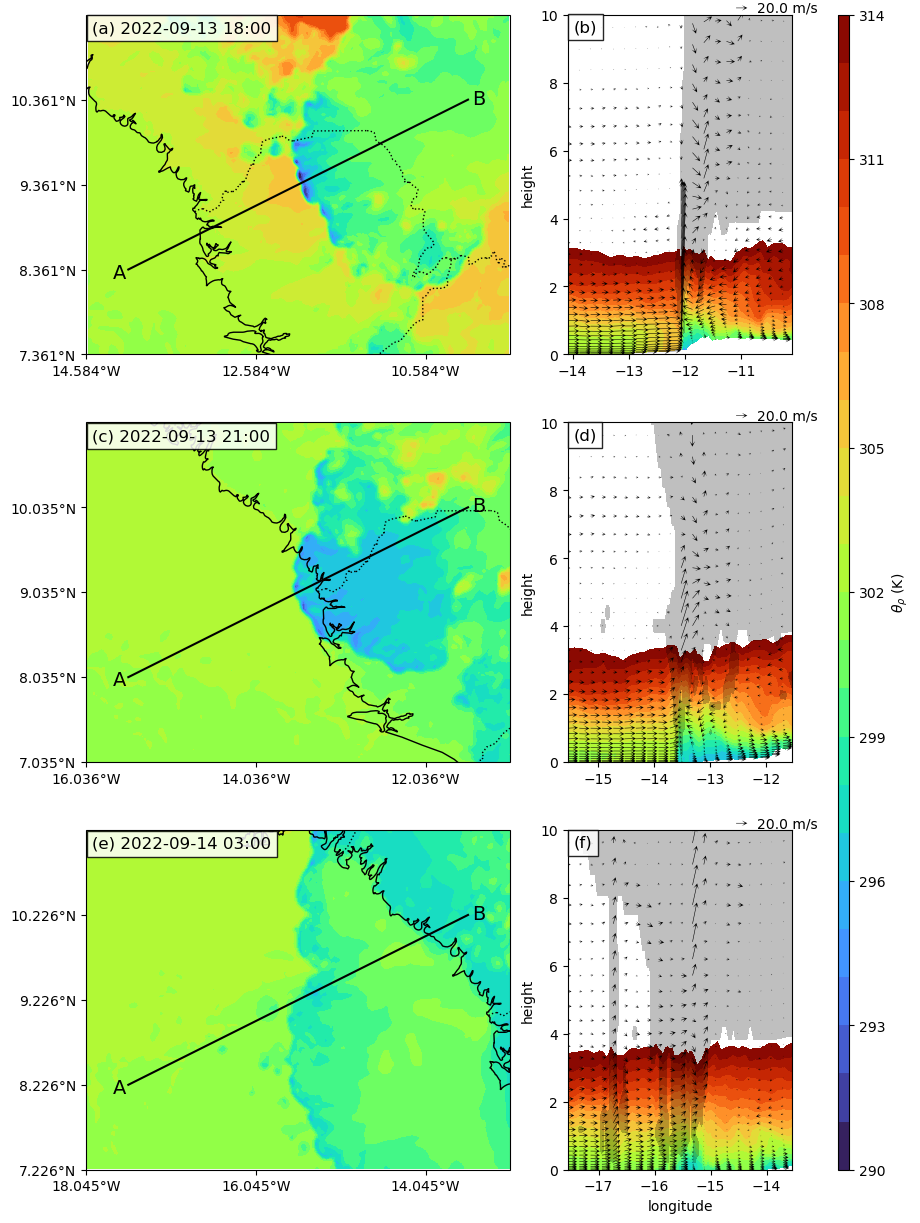

In [36]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

num_rows = 3
num_cols = 2
lat_interval = 1.0
lon_interval = 2.0

fig = plt.figure(figsize=(10, 5 * num_rows))  # Adjust figure size as needed
gs = fig.add_gridspec(num_rows, num_cols + 1, width_ratios=[2, 1, 0.05], wspace=0.2)

option = 'southernSquall'

i = 0
l = 0
for location in ['land','coast','water']:

    # read in info
    centLat = coordinates[option][location]['lat']
    centLon = coordinates[option][location]['lon']
    time = coordinates[option][location]['time']
    validTime = datetime.strptime(time,'%Y-%m-%d %H:%M:%S')
    print(validTime, centLat, centLon)
    
    # Set the x and y axis limits for the map
    minLat = centLat-2.0
    maxLat = centLat+2.0
    minLon = centLon-2.5
    maxLon = centLon+2.5
    print(minLat,maxLat,minLon,maxLon)


    # Add the map panel to the first column
    ax_map = fig.add_subplot(gs[i, 0], projection=ccrs.PlateCarree())
    ax_map.set_extent([minLon, maxLon, minLat, maxLat], crs=ccrs.PlateCarree()) # Set zoomed-in extent
    ax_map.add_feature(cfeature.COASTLINE)
    ax_map.add_feature(cfeature.BORDERS, linestyle=':')
    # Add Latitudes
    ax_map.set_yticks(np.arange(minLat, maxLat, lat_interval), crs=ccrs.PlateCarree())
    lat_formatter = LatitudeFormatter()
    ax_map.yaxis.set_major_formatter(lat_formatter)
    # Add Longitudes
    ax_map.set_xticks(np.arange(minLon, maxLon, lon_interval), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    ax_map.xaxis.set_major_formatter(lon_formatter)
    
    # fhr = 49
    
    # validTime = initTime+timedelta(hours=(fhr))
    # read file name as a dataset
    print(validTime)
    validTimeFormatted = datetime.strftime(validTime, '%Y-%m-%d_%H:%M')
    fname='%smpas_init_%s%s_valid_%s_latlon_%s.nc'%(outputDir,TODAY,HH,validTimeFormatted,domain)
    print(fname)
    ds = xr.open_dataset(fname).squeeze()
    
    # calculate density potential temperature to identify cold pools
    theta = ds['theta'].isel(nVertLevels=0).sel(latitude=slice(minLat,maxLat),longitude=slice(minLon,maxLon))
    qv = ds['qv'].isel(nVertLevels=0).sel(latitude=slice(minLat,maxLat),longitude=slice(minLon,maxLon))
    qc = ds['qc'].isel(nVertLevels=0).sel(latitude=slice(minLat,maxLat),longitude=slice(minLon,maxLon))
    qr = ds['qr'].isel(nVertLevels=0).sel(latitude=slice(minLat,maxLat),longitude=slice(minLon,maxLon))
    thetaRhoSurf = theta*(1.0 + (0.608*qv) - qc - qr)
    
    print(thetaRhoSurf.min().values,thetaRhoSurf.max().values)
    
    # redefine minLat, maxLat, etc for the cross section
    minLon = centLon-2.0
    maxLon = centLon+2.0
    if (option == 'northernSquall'):
        minLat = centLat+0.5
        maxLat = centLat-0.5
        uMotion = -17.7
        vMotion = 6.6
    else:
        minLat = centLat-1
        maxLat = centLat+1
        uMotion = -15.2
        vMotion = 2.2
    # plot
    [X, Y] = np.meshgrid(thetaRhoSurf.longitude, thetaRhoSurf.latitude)
    ax_map.contourf(X,Y,thetaRhoSurf, cmap='turbo', levels = np.arange(290, 315, 1))
    ax_map.plot([minLon, maxLon], [minLat, maxLat], color='k', transform=ccrs.PlateCarree())
    # add A and B to cross section start and end
    ax_map.text(minLon-0.18, minLat-0.1, 'A', fontsize=14)
    ax_map.text(maxLon+0.05, maxLat-0.05, 'B', fontsize=14)

    # add panel label
    label = f"({chr(l+97)}) {validTime.strftime('%Y-%m-%d %H:%M')}"
    ax_map.text(0.015, 0.982, label,
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax_map.transAxes,
        fontsize='12', bbox=dict(facecolor='white', alpha=0.85))
    l += 1    
        
    # # # Extract the cross-section
    parallel_wind = vertical_cross_section_angled(ds, minLat, minLon, maxLat, maxLon, 'parallel_wind', \
                                                  uMotion=uMotion, vMotion=vMotion, uzonal_var='uReconstructZonal',
                                                 umeridional_var='uReconstructMeridional')
    print(parallel_wind.min(),parallel_wind.max())
    w_wind = vertical_cross_section_angled(ds, minLat, minLon, maxLat, maxLon, 'w')
    # z_iso  = vertical_cross_section_angled(ds, minLat, minLon, maxLat, maxLon, 'z_isobaric')*1.0e-3
    field1 = vertical_cross_section_angled(ds, minLat, minLon, maxLat, maxLon, varName)
    field2 = vertical_cross_section_angled(ds, minLat, minLon, maxLat, maxLon, 'condensate')
    print(field2.min(),field2.max())
    del(ds)
    
    # now read vertical grid
    fname='/glade/work/rberrios/MPAS/cpex-cv/%s%s/latlon.nc'%(TODAY,HH)
    ds = xr.open_dataset(fname).squeeze()
    z_stag = vertical_cross_section_angled(ds, minLat, minLon, maxLat, maxLon, 'zgrid')
    del(ds)
    # unstagger
    z_unstag = 0.5*(z_stag[1:,:].values+z_stag[:-1,:].values)*0.001 # in km
    w_unstag = 0.5*(w_wind[1:,:].values+w_wind[:-1,:].values)
    
    # Plotting the cross section:
    # Get the SubplotSpec for the current Skew-T panel
    subplot_spec = gs[i, 1]  # Skew-Ts are in the second and third columns
    
    ax = fig.add_subplot(subplot_spec)
    
    [X, dummy] = np.meshgrid(field1.longitude, np.arange(0,len(field1[:,0])))
    im=ax.contourf(X, z_unstag, field1,cmap='turbo',levels=np.arange(290, 315, 1))
    # plot the 1e-5 g/kg condensate isosurface
    mask = field2 >= 1e-5
    ax.contourf(X, z_unstag, mask,colors='k',alpha=0.25,levels=[0.5,1],extend='max')
    ax.set(ylim=(0,10),ylabel='height')
    
    # add wind vectors
    # [X, Y] = np.meshgrid(field1.longitude, w_wind.u_iso_levels)
    reference_magnitude_ms = 20.0  # Reference wind speed
    desired_length_meters = 2000  # Desired arrow length on the plot in the units of X and z_iso
    
    scale_factor = desired_length_meters / reference_magnitude_ms
    
    Q = ax.quiver(X[::, ::5], z_unstag[::, ::5], parallel_wind[::, ::5], 20.0 * w_unstag[::, ::5],
                  color='k', units='xy', scale_units='xy', scale=scale_factor, headwidth=10, headlength=10)
    
    # You can add a reference arrow and label for clarity
    qk = ax.quiverkey(Q, 0.8, 1.02, reference_magnitude_ms, f'{reference_magnitude_ms} m/s',
                       labelpos='E', coordinates='axes')

    # add panel label to the cross section
    label = f"({chr(l+97)})"
    ax.text(0.025, 0.985, label,
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize='12', bbox=dict(facecolor='white', alpha=0.85))
    l += 1
    # increment the row counter
    i=i+1


ax.set_xlabel('longitude')
# cb=plt.colorbar(im,orientation='vertical',shrink=0.75)
colorbar_ax = fig.add_subplot(gs[:, num_cols])
cb = fig.colorbar(im, cax=colorbar_ax, orientation='vertical',shrink=0.75)
cb.set_label(r'$\theta_{\rho}$ (K)')
plt.savefig('./Figures/%s_multi-panels_thetarho+srflow.jpeg'%(option),bbox_inches='tight',dpi=150)

### Plot wind profiles and calculate c/du

2022-09-13 18:00:00 9.361 -12.084
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld/intrp_output/mpas_init_2022091212_valid_2022-09-13_18:00_latlon_westAfrica.nc
shear magnitude: -31.325737
cold pool strength: 27.480014
c/du: 0.877234
2022-09-13 21:00:00 9.035 -13.536
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld/intrp_output/mpas_init_2022091212_valid_2022-09-13_21:00_latlon_westAfrica.nc
shear magnitude: -20.746219
cold pool strength: 23.793985
c/du: 1.146907
2022-09-14 03:00:00 9.226 -15.545
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld/intrp_output/mpas_init_2022091212_valid_2022-09-14_03:00_latlon_westAfrica.nc
shear magnitude: -4.983114
cold pool strength: 16.856728
c/du: 3.382770
2022-09-14 08:00:00 14.692 -16.055
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld/intrp_output/mpas_init_2022091212_valid_2022-09-14_08:00_latlon_westAfrica.nc
shear magnitude: -21.838301
cold 

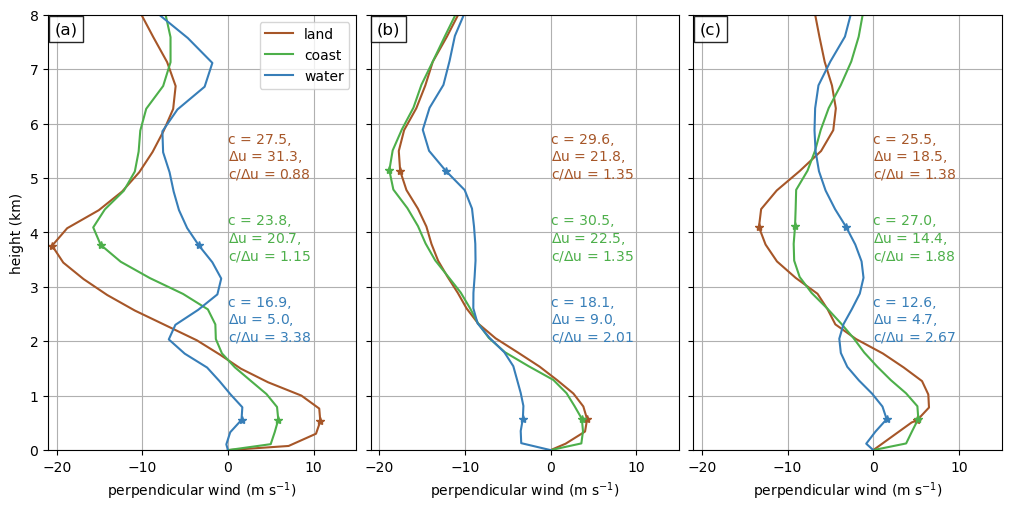

In [18]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(10,5), sharey=True, sharex=True, constrained_layout=True)
# color blind friendly colors
lineColors = {
    'water': '#377eb8',
    'land': '#a65628',
    'coast': '#4daf4a',
}
i = 0
for option in ['southernSquall','northernSquall','southernSquallNoon']:
    j=0
    for location in ['land','coast','water']:
    
        # read in info
        centLat = coordinates[option][location]['lat']
        centLon = coordinates[option][location]['lon']
        time = coordinates[option][location]['time']
        validTime = datetime.strptime(time,'%Y-%m-%d %H:%M:%S')
        print(validTime, centLat, centLon)
    
        validTimeFormatted = datetime.strftime(validTime, '%Y-%m-%d_%H:%M')

        if ('Noon' in option):
            outputDir = '%s%s%s_noomld_perpnoon/intrp_output/'%(mpasDir,TODAY,HH)
        else:
            outputDir = '%s%s%s_noomld/intrp_output/'%(mpasDir,TODAY,HH)
            
        fname='%smpas_init_%s%s_valid_%s_latlon_%s.nc'%(outputDir,TODAY,HH,validTimeFormatted,domain)
        print(fname)
        ds = xr.open_dataset(fname).squeeze()
        
        # redefine minLat, maxLat, etc for the cross section
        minLon = centLon-2.0
        maxLon = centLon+2.0

        pbot = 950.0e2
        if (option == 'northernSquall'):
            minLat = centLat+0.5
            maxLat = centLat-0.5
            ptop = 550.0e2
        else:
            minLat = centLat-1
            maxLat = centLat+1
            if ('Noon' in option):
                ptop = 625.0e2
            else:
                ptop = 650.0e2
        
        # # # Extract the cross-section
        parallel_wind = vertical_cross_section_angled(ds, minLat, minLon, maxLat, maxLon, 'parallel_wind')
        z_iso  = vertical_cross_section_angled(ds, minLat, minLon, maxLat, maxLon, 'z_isobaric')*1.0e-3
        field = vertical_cross_section_angled(ds, minLat, minLon, maxLat, maxLon, 'thetaRho')
        del(ds)

        # plot vertical profile of winds
        ax[i].plot(parallel_wind.sel(longitude=centLon-0.5,method='nearest'),\
                   z_iso.sel(longitude=centLon-0.5,method='nearest'),color=lineColors[location],label=location)
    
        # now read vertical grid
        fname='/glade/work/rberrios/MPAS/cpex-cv/%s%s/latlon.nc'%(TODAY,HH)
        ds = xr.open_dataset(fname).squeeze()
        z_stag = vertical_cross_section_angled(ds, minLat, minLon, maxLat, maxLon, 'zgrid')
        del(ds)
        # unstagger
        z_unstag = 0.5*(z_stag[1:,:].values+z_stag[:-1,:].values)*0.001 # in km
    
        # done reading, now we calculate
        # calculate line-perpendicular shear
        ushear = parallel_wind.sel(longitude=centLon-0.5,u_iso_levels=ptop,method='nearest')-\
                 parallel_wind.sel(longitude=centLon-0.5,u_iso_levels=pbot,method='nearest')
        print('shear magnitude: %f'%(ushear.values))

        # add symbols where we're taking the winds
        ax[i].plot(parallel_wind.sel(longitude=centLon-0.5,u_iso_levels=ptop,method='nearest'),
                 z_iso.sel(longitude=centLon-0.5,z_iso_levels=ptop,method='nearest'),
                 '*',color=lineColors[location])
        ax[i].plot(parallel_wind.sel(longitude=centLon-0.5,u_iso_levels=pbot,method='nearest'),
                 z_iso.sel(longitude=centLon-0.5,z_iso_levels=pbot,method='nearest'),
                 '*',color=lineColors[location])
    
        # check buoyancy
        refProf = field.sel(longitude=centLon-0.5, method='nearest')
        buoyancy = 9.81*((field-refProf)/refProf)
        # i don't think we should only consider negative buoyancy, or yes... yes
        buoyancy = buoyancy.where(buoyancy<0.0,other=0.0)
        c = np.sqrt(-2.*np.trapz(buoyancy[0:24,:],z_unstag[0:24,:]*1.0e3,axis=0))
        print('cold pool strength: %f'%c.max())
        print('c/du: %f'%(c.max()/np.fabs(ushear.values)))

        ax[i].grid(True)
        ax[i].text(0,5.0-j*1.5,\
                   'c = %2.1f,\n$\Delta$u = %2.1f,\nc/$\Delta$u = %2.2f'\
                   %(c.max(),np.fabs(ushear.values),c.max()/np.fabs(ushear.values)),
                   color=lineColors[location])
        j+=1
    # add panel labels
    label = "("+chr(i+97)+")"
    ax[i].text(0.02, 0.985, label,
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax[i].transAxes,
        fontsize='12', bbox=dict(facecolor='white', alpha=0.85)) 
    i = i+1
ax[0].set(ylim=(0,8),xlim=(-21,15),ylabel='height (km)',xlabel='perpendicular wind (m s$^{-1}$)')
ax[1].set(xlabel='perpendicular wind (m s$^{-1}$)')
ax[-1].set(xlabel='perpendicular wind (m s$^{-1}$)')
ax[0].legend()
plt.savefig('./Figures/wind_profiles_land-coast-water.jpeg',bbox_inches='tight',dpi=300)